In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import numpy as np
import copy
import os
import matplotlib
import matplotlib.pyplot as plt
# Avoid type 3 characters (?)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# from google.colab import drive
# drive.mount('/content/drive')



#### save directory path
directory_path = '/content/drive/MyDrive/Colab Notebooks/results/080324_combined'


In [ ]:
# @title REN and MLP classes for optimizer
### This is the model for the algorithm. Substitute with REN class for the other examples

# Robust REN implementation in the acyclic version
class REN(nn.Module):
    def __init__(self, m, p, n, l, bias=False, mode="l2stable", gamma=0.3, Q=None, R=None, S=None, device=torch.device('cuda')):
        super().__init__()
        self.m = m  # input dimension
        self.n = n  # state dimension
        self.l = l  # dimension of v(t) and w(t)
        self.p = p  # output dimension
        self.device = device
        s = max(m, p)
        # # # # # # # # # IQC specification # # # # # # # # #
        self.Q, self.R, self.S = self._set_mode(mode, gamma, Q, R, S)
        # # # # # # # # # Training parameters # # # # # # # # #
        # Auxiliary matrices:
        std = 0.01

        self.x0 = nn.Parameter((torch.randn(1, n, device=device) * std ))
        self.X = nn.Parameter((torch.randn(2*n+l, 2*n+l, device=device) * std))
        self.Y = nn.Parameter((torch.randn(n, n, device=device) * std))
        self.x3 = nn.Parameter((torch.randn(28, 28, device = device) * std))
        self.y3 = nn.Parameter((torch.randn(28, 28, device = device) * std))
        self.x3corner = nn.Parameter((torch.randn(10, 10, device = device) * std))
        self.y3corner = nn.Parameter((torch.randn(10, 10, device = device) * std))
        #self.X3 = nn.Parameter((torch.randn(s, s, device=device) * std))
        #self.Y3 = nn.Parameter((torch.randn(s, s, device=device) * std))

        # NN state dynamics:
        self.b2 = nn.Parameter((torch.randn(n, 28, device=device) * std))
        self.d12 = nn.Parameter((torch.randn(n, 28, device=device) * std))
        self.b2last = nn.Parameter((torch.randn(n, 10, device=device) * std))
        self.d12last = nn.Parameter((torch.randn(n, 10, device=device) * std))
        #self.B2 = nn.Parameter((torch.randn(n, m, device=device) * std))
        #self.D12 = nn.Parameter((torch.zeros(l, m, device=device) * std))
        # NN output:
        self.c2 = nn.Parameter((torch.randn(28, n, device=device) * std))
        self.d21 = nn.Parameter((torch.randn(28, l, device=device) * std))
        self.c2last = nn.Parameter((torch.randn(10, n, device=device) * std))
        self.d21last = nn.Parameter((torch.randn(10, l, device=device) * std))
        # self.C2 = nn.Parameter((torch.randn(p, n, device=device) * std))
        # self.D21 = nn.Parameter((torch.randn(p, l, device=device) * std))
        if bias:
            self.bx = nn.Parameter(torch.randn(n, device=device) * std)
            self.bv = nn.Parameter(torch.randn(l, device=device) * std)
            self.bu = nn.Parameter(torch.randn(p, device=device) * std)
        else:
            self.bx = torch.zeros(n, device=device)
            self.bv = torch.zeros(l, device=device)
            self.bu = torch.zeros(p, device=device)
        # # # # # # # # # Non-trainable parameters # # # # # # # # #
        # Auxiliary elements

        self.x = torch.zeros(1, n, device=device)

        self.epsilon = 0.001
        self.F = torch.zeros(n, n, device=device)
        self.B1 = torch.zeros(n, l, device=device)
        self.E = torch.zeros(n, n, device=device)
        self.Lambda = torch.ones(l, device=device)
        self.C1 = torch.zeros(l, n, device=device)
        self.D11 = torch.zeros(l, l, device=device)
        self.D22 = torch.zeros(p, m, device=device)
        self.P = torch.zeros(n, n, device=device)
        self.P_cal = torch.zeros(n, n, device=device)
        self.X3 = torch.zeros(s, s, device=device)
        self.Y3 = torch.zeros(s, s, device=device)
        self.B2 = torch.zeros(n, m, device=device)
        self.D12 = torch.zeros(l, m, device=device)
        self.C2 = torch.zeros(p, n, device=device)
        self.D21 = torch.zeros(p, l, device=device)
        self.set_model_param()

    def set_model_param(self):
        n, l = self.n, self.l
        Q, R, S = self.Q, self.R, self.S
        mat1 = torch.eye(28*10).to(self.device)
        self.X3 = torch.block_diag(torch.kron(mat1, self.x3), self.x3corner)
        self.Y3 = torch.block_diag(torch.kron(mat1, self.y3), self.y3corner)
        mat2 = torch.ones((1, 28*10)).to(self.device)
        self.B2 = torch.hstack((torch.kron(mat2, self.b2), self.b2last))
        self.D12 = torch.hstack((torch.kron(mat2, self.d12), self.d12last))
        mat3 = torch.ones((28*10, 1)).to(self.device)
        self.C2 = torch.vstack((torch.kron(mat3, self.c2), self.c2last))
        self.D21 = torch.vstack((torch.kron(mat3, self.d21), self.d21last))
        # Calculate D22:
        M = torch.matmul(self.X3.T, self.X3) + self.Y3 - self.Y3.T + self.epsilon * torch.eye(self.X3.shape[0], device=self.device)
        s = max(self.m, self.p)
        M_tilde = torch.matmul(torch.eye(s, device=self.device) - M, torch.inverse(torch.eye(s, device=self.device) + M))
        M_tilde = M_tilde[0:self.p, 0:self.m]
        Lq = torch.linalg.cholesky(-self.Q).T
        Lr = torch.linalg.cholesky(self.R - torch.matmul(self.S,  torch.matmul(torch.inverse(self.Q), self.S.T))).T
        self.D22 = -torch.matmul(torch.inverse(self.Q), self.S.T) + torch.matmul(torch.inverse(Lq),
                                                                                 torch.matmul(M_tilde, Lr))
        # Calculate psi_r:
        R_cal = R + torch.matmul(S, self.D22) + torch.matmul(S, self.D22).T + torch.matmul(self.D22.T,
                                                                                           torch.matmul(Q, self.D22))
        R_cal_inv = torch.linalg.inv(R_cal)
        C2_cal = torch.matmul(torch.matmul(self.D22.T, self.Q) + self.S, self.C2).T
        D21_cal = torch.matmul(torch.matmul(self.D22.T, self.Q) + self.S, self.D21).T - self.D12
        vec_r = torch.cat((C2_cal, D21_cal, self.B2), dim=0)
        psi_r = torch.matmul(vec_r, torch.matmul(R_cal_inv, vec_r.T))
        # Calculate psi_q:
        vec_q = torch.cat((self.C2.T, self.D21.T, torch.zeros(self.n, self.p, device=self.device)), dim=0)
        psi_q = torch.matmul(vec_q, torch.matmul(self.Q, vec_q.T))
        # Create H matrix:
        H = torch.matmul(self.X.T, self.X) + self.epsilon * torch.eye(2*n+l, device=self.device) + psi_r - psi_q
        h1, h2, h3 = torch.split(H, [n, l, n], dim=0)
        H11, H12, H13 = torch.split(h1, [n, l, n], dim=1)
        H21, H22, _ = torch.split(h2, [n, l, n], dim=1)
        H31, H32, H33 = torch.split(h3, [n, l, n], dim=1)
        self.P_cal = H33
        # NN state dynamics:
        self.F = H31
        self.B1 = H32
        # NN output:
        self.E = 0.5 * (H11 + self.P_cal + self.Y - self.Y.T)
        # v signal:  [Change the following 2 lines if we don't want a strictly acyclic REN!]
        self.Lambda = 0.5*torch.diag(H22)
        self.D11 = -torch.tril(H22, diagonal=-1)
        self.C1 = -H21
        # Matrix P
        self.P = torch.matmul(self.E.T, torch.matmul(torch.inverse(self.P_cal), self.E))


    def forward(self, u, x, t):
        decay_rate = 0.95
        vec = torch.zeros(self.l, device=self.device)
        epsilon = torch.zeros(self.l, device=self.device)
        if self.l > 0:
            vec[0] = 1
            v = F.linear(x, self.C1[0, :]) + F.linear(u, self.D12[0, :]) + (decay_rate**t)*self.bv[0]
            epsilon = epsilon + vec * torch.tanh(v/self.Lambda[0])
        for i in range(1, self.l):
            vec = torch.zeros(self.l, device=self.device)
            vec[i] = 1
            v = F.linear(x, self.C1[i, :]) + F.linear(epsilon,self.D11[i, :]) + F.linear(u, self.D12[i, :]) + (decay_rate**t)*self.bv[i]
            epsilon = epsilon + vec * torch.tanh(v/self.Lambda[i])
        E_x_ = F.linear(x, self.F) + F.linear(epsilon, self.B1) + F.linear(u, self.B2) + (decay_rate**t)*self.bx

        x_ = F.linear(E_x_, self.E.inverse())

        y = F.linear(x, self.C2) + F.linear(epsilon, self.D21) + F.linear(u, self.D22) + (decay_rate**t)*self.bu

        return y, x_

    def _set_mode(self, mode, gamma, Q, R, S, eps=1e-4):
        # We set Q to be negative definite. If Q is nsd we set: Q - \epsilon I.
        # I.e. The Q we define here is noted as \matcal{Q} in REN paper.
        if mode == "l2stable":
            Q = -(1. / gamma) * torch.eye(self.p, device=self.device)
            R = gamma * torch.eye(self.m, device=self.device)
            S = torch.zeros(self.m, self.p, device=self.device)
        elif mode == "input_p":
            if self.p != self.m:
                raise NameError("Dimensions of u(t) and y(t) need to be the same for enforcing input passivity.")
            Q = torch.zeros(self.p, self.p, device=self.device) - eps * torch.eye(self.p, device=self.device)
            R = -2. * gamma * torch.eye(self.m, device=self.device)
            S = torch.eye(self.p, device=self.device)
        elif mode == "output_p":
            if self.p != self.m:
                raise NameError("Dimensions of u(t) and y(t) need to be the same for enforcing output passivity.")
            Q = -2. * gamma * torch.eye(self.p, device=self.device)
            R = torch.zeros(self.m, self.m, device=self.device)
            S = torch.eye(self.m, device=self.device)
        else:
            print("Using matrices R,Q,S given by user.")
            # Check dimensions:
            if not(len(R.shape) == 2 and R.shape[0] == R.shape[1] and R.shape[0] == self.m):
                raise NameError("The matrix R is not valid. It must be a square matrix of %ix%i." % (self.m, self.m))
            if not(len(Q.shape) == 2 and Q.shape[0] == Q.shape[1] and Q.shape[0] == self.p):
                raise NameError("The matrix Q is not valid. It must be a square matrix of %ix%i." % (self.p, self.p))
            if not (len(S.shape) == 2 and S.shape[0] == self.m and S.shape[1] == self.p):
                raise NameError("The matrix S is not valid. It must be a matrix of %ix%i." % (self.m, self.p))
            # Check R=R':
            if not (R == R.T).prod():
                raise NameError("The matrix R is not valid. It must be symmetric.")
            # Check Q is nsd:
            eigs, _ = torch.linalg.eig(Q)
            if not (eigs.real <= 0).prod():
                print('oh!')
                raise NameError("The matrix Q is not valid. It must be negative semidefinite.")
            if not (eigs.real < 0).prod():
                # We make Q negative definite: (\mathcal{Q} in the REN paper)
                Q = Q - eps * torch.eye(self.p, device=self.device)
        return Q, R, S

    def validate_LMI(self):
        # Validate eq21
        W = 2 * torch.diag(self.Lambda) - self.D11 - self.D11.T
        lmi1 = torch.cat([torch.cat([self.E+self.E.T-self.P_cal, -self.C1.T, torch.matmul(self.S,self.C2).T], dim=1),
                         torch.cat([-self.C1, W, torch.matmul(self.S,self.D21).T-self.D12], dim=1),
                         torch.cat([torch.matmul(self.S,self.C2),
                                    torch.matmul(self.S,self.D21)-self.D12.T,
                                    self.R+torch.matmul(self.S,self.D22)+torch.matmul(self.S,self.D22).T], dim=1)],
                        dim=0)
        lmi2 = torch.matmul(torch.cat([self.F, self.B1, self.B2], dim=1).T,
                            torch.matmul(torch.inverse(self.P_cal), torch.cat([self.F, self.B1, self.B2], dim=1))
                            )
        lmi3 = torch.matmul(torch.cat([self.C2, self.D21, self.D22], dim=1).T,
                            torch.matmul(self.Q, torch.cat([self.C2, self.D21, self.D22], dim=1))
                            )

        lmi = lmi1 - lmi2 + lmi3
        try:
            l21 = torch.linalg.cholesky(lmi)
            print("Eq (21) is validated")
        except RuntimeError:
            l21 = None
            print("ERROR: Eq (21) isn't validated")
        # Validate eq22
        R_cal = self.R + torch.matmul(self.S, self.D22) + torch.matmul(self.S, self.D22).T + \
                torch.matmul(self.D22.T, torch.matmul(self.Q, self.D22))
        L1 = torch.linalg.cholesky(R_cal)
        W = 2 * torch.diag(self.Lambda) - self.D11 - self.D11.T
        lmi1 = torch.cat([torch.cat([self.E + self.E.T - self.P_cal, -self.C1.T, -self.F.T], dim=1),
                          torch.cat([-self.C1, W, self.B1.T], dim=1),
                          torch.cat([self.F, self.B1, self.P_cal], dim=1)],
                          dim=0)
        C2_cal = torch.matmul(torch.matmul(self.D22.T, self.Q) + self.S, self.C2).T
        D21_cal = torch.matmul(torch.matmul(self.D22.T, self.Q) + self.S, self.D21).T - self.D12
        lmi2 = torch.matmul(torch.cat([C2_cal, D21_cal, self.B2], dim=0),
                            torch.matmul(torch.inverse(R_cal), torch.cat([C2_cal, D21_cal, self.B2], dim=0).T)
                            )
        lmi3 = torch.matmul(torch.cat([self.C2.T, self.D21.T, torch.zeros(self.n,self.p, device=self.device)], dim=0),
                            torch.matmul(self.Q, torch.cat([self.C2.T,self.D21.T,torch.zeros(self.n,self.p, device=self.device)], dim=0).T)
                            )
        lmi = lmi1-lmi2+lmi3
        try:
            l22 = torch.linalg.cholesky(lmi)
            print("Eq (22) is validated")
        except RuntimeError:
            l22 = None
            print("ERROR: Eq (22) isn't validated")
        return l21, l22

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

In [ ]:
### DATA LOADING, CUDA and SEED


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1234)
np.random.seed(1234)

flag = 'MNIST'
batch_size = 128

# Both datasets feature 60000 images (28x28) for training and 10000 for testing. We will use 80% of the total training images for (meta) training and leave the remaining 20% for validation.
if flag == 'MNIST':
    # MNIST Data loading
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    # Download and load the test data
    testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
elif flag == 'FashionMNIST':
    # FashionMNIST Data loading
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True, train=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    # Download and load the test data
    testset = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True, train=False, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)


meta_train_split = .8
# Creating data indices for training and validation splits:
indexes = list(range(len(trainset)))
split = int(np.floor(meta_train_split * len(trainset)))
meta_train_indexes, train_indexes = indexes[:split], indexes[split:]
print(len(meta_train_indexes))

# Creating PT data samplers and loaders:
meta_trainsampler = SubsetRandomSampler(meta_train_indexes)
trainsampler = SubsetRandomSampler(train_indexes)

meta_trainloader = DataLoader(trainset, batch_size=batch_size, sampler=meta_trainsampler)
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=trainsampler)

# i = 0
# train_loader_iter = iter(train_loader)

# while True:
#     images, labels = next(train_loader_iter)
#     # try:
#     #     images, labels = next(train_loader_iter)
#     # except StopIteration:
#     #     train_loader_iter = iter(train_loader)
#     #     images, labels = next(train_loader_iter)
#     i += 1
#     if i == 1000:
#         break


n_params = 7850



# optimizer = torch.optim.SGD(learnt_optimizer.parameters(), lr=0.001, momentum=0.01)



48000


In [ ]:
#### PARAMETERS FOR META TRAINING



eta = 1e-3          ### step-size inner model
gamma = 5e-2

T = 50             ### Horizon inner training

iterations = 10   ### How many initial conditions to try for one step ot meta-training

epochs = 50        ### meta-training steps

activation_type = 'tanh' ### choose inner network architecture


#######################################

# Initialize objects

meta_trainloader_iter = iter(meta_trainloader)
weights = 0.01 * torch.rand(10, 784, device=device)
bias = 0.01 * torch.rand(1, 10, device=device)
delta_0 = torch.hstack((torch.reshape(weights, (1, weights.numel())), torch.reshape(bias, (1, bias.numel()))))


omega = SimpleMLP(2*delta_0.shape[1] + 1, 3, 3, delta_0.shape[1]) #REN(m=n_params, p=n_params, n=3, l=3, bias=True, device=device)
omega.to(device)
print(f'Parameters of SimpleMLP: {sum(p.numel() for p in omega.parameters() if p.requires_grad)}\n')


zeta = REN(m=n_params, p=n_params, n=3, l=3, bias=True, device=device)
zeta.to(device)
zeta.set_model_param()
print(f'Parameters of REN: {sum(p.numel() for p in zeta.parameters() if p.requires_grad)}\n')


optimizer = torch.optim.Adam(list(omega.parameters()) + list(zeta.parameters()), lr=1e-2)



def forward_propagation(images, weights, bias, activation_type):
  if activation_type == 'tanh':
    return torch.tanh(images @ weights.T + bias)
  elif activation_type == 'sigmoid':
    return torch.sigmoid(images @ weights.T + bias)
  elif activation_type == 'relu':
    return torch.relu(images @ weights.T + bias)



Parameters of SimpleMLP: 78518

Parameters of REN: 10173



In [ ]:
# @title META TRAINING
### META TRAINING




for epoch in range(epochs):

    optimizer.zero_grad()


    meta_loss = torch.zeros(1, device=device)

    count_fallback = 0

    for i in range(iterations):

        # classifier = MLP(activation_type).to(device)

        # weights = copy.deepcopy(classifier.hidden.weight)
        # bias = copy.deepcopy(classifier.hidden.bias)

        # std = 0.1
        # weights = std * torch.randn(10, 784)
        # bias = std * torch.randn(1, 10)
        # weights = torch.rand(10, 784, device=device) - 0.5
        # bias = torch.rand(1, 10, device=device) - 0.5

        weights = 0.01 * torch.rand(10, 784, device=device)
        bias = 0.01 * torch.rand(1, 10, device=device)

        delta_0 = torch.hstack((torch.reshape(weights, (1, weights.numel())), torch.reshape(bias, (1, bias.numel()))))

        loss = torch.zeros(1, device=device)
        mloss = torch.zeros(1, device=device)

        for t in range(T):

            loss = torch.zeros(1, device=device) ######### TO REMOVE (?)


            # Manual Gradient Computation for a Single Batch

            try:
                # images, labels = next(trainloader_iter)
                images, labels = next(meta_trainloader_iter)
            except StopIteration:
                # trainloader_iter = iter(trainloader)©†
                # images, labels = next(trainloader_iter)
                meta_trainloader_iter = iter(meta_trainloader)
                images, labels = next(meta_trainloader_iter)

            images = images.to(device)
            labels = labels.to(device)

            inputs = images.view(images.shape[0], -1)

            # Here logits are actually tanh outputs, using the term for consistency with nn.CrossEntropyLosss
            logits = forward_propagation(inputs, weights, bias, activation_type)

            # CrossEntropyLoss expects logits, but we have passed through tanh, so let's manually compute the softmax cross-entropy loss
            softmax_outputs = torch.softmax(logits, dim=1)
            log_softmax_outputs = torch.log(softmax_outputs)
            y_one_hot = F.one_hot(labels, num_classes=10).float()

            loss = loss - torch.sum(log_softmax_outputs * y_one_hot) / images.size(0)  # Manual cross-entropy loss computation

            # Backward Pass (Manual Gradient Computation)
            # Gradient of loss w.r.t. softmax outputs
            grad_loss_wrt_softmax_outputs = softmax_outputs - y_one_hot

            # Backpropagate through activation function
            if activation_type == 'tanh':
              grad_softmax_outputs_wrt_logits = 1 - torch.square(logits)  # Derivative of tanh
            elif activation_type == 'sigmoid':
              grad_softmax_outputs_wrt_logits = torch.exp(-logits)/(1+torch.exp(-logits))/(1+torch.exp(-logits)) #derivative of sigmoid


            grad_loss_wrt_logits = grad_loss_wrt_softmax_outputs * grad_softmax_outputs_wrt_logits

            # Compute gradients w.r.t. weights and biases
            grad_loss_wrt_weights = torch.matmul(grad_loss_wrt_logits.T, inputs) / images.size(0)
            grad_loss_wrt_bias = torch.sum(grad_loss_wrt_logits, dim=0) / images.size(0)

            delta_t = torch.hstack((torch.reshape(weights, (1, weights.numel())), torch.reshape(bias, (1, bias.numel()))))
            grad_t = torch.hstack((torch.reshape(grad_loss_wrt_weights, (1, grad_loss_wrt_weights.numel())), torch.reshape(grad_loss_wrt_bias, (1, grad_loss_wrt_bias.numel()))))

            omega_t = omega.forward(torch.hstack((delta_t, grad_t, torch.reshape(loss, (1, 1)))))

            if t == 0:
                # vt, learnt_optimizer.x = learnt_optimizer.forward(delta_0, torch.zeros_like(learnt_optimizer.x0, device=device))
                zt, zeta.x = zeta.forward(delta_0, zeta.x0, t)
            else:
                zt, zeta.x = zeta.forward(torch.zeros_like(delta_0, device=device), zeta.x, t)

            eta_t = 1/(100+t)

            vt = omega_t * torch.norm(zt) / torch.norm(omega_t)
            # if torch.norm(omega_t)<torch.norm(zt):
            #   vt = omega_t
            # else:
            #   vt = zt
            #   count_fallback += 1


            #mloss= mloss - torch.abs(torch.norm(vt)-1000)
            mloss = mloss - (1 - gamma)**(T - 1 - t) * torch.sum(log_softmax_outputs * y_one_hot) / images.size(0) #+  0.8 ** (t) * 0.1 *torch.norm(vt) ** 2

            # if t == T-1:
            #   mloss= loss

            weights = weights - eta_t*grad_loss_wrt_weights + torch.reshape(vt[0, 0:weights.numel()], weights.shape)
            bias = bias - eta_t*grad_loss_wrt_bias + torch.reshape(vt[0, weights.numel():], bias.shape)

            # print(f"Optimization step {t} - loss {loss.detach().numpy()}\n")

        # print(f"Iteration {i} - average mloss {mloss.detach().numpy() / T}\n")

        meta_loss = meta_loss + mloss

    print(f"Epoch {epoch+1} - average metaloss {meta_loss.cpu().detach().numpy() / (iterations)}\n")

    meta_loss.backward()

    optimizer.step()
    zeta.set_model_param()

    if (epoch + 1) % 5 == 0:
      file_path = directory_path + "/" + flag + "_l2o_Adam_lr1e-2_epoch:" + str(epoch+1) + "_T" + str(T) + "_iter" + str(iterations) + "_eta" + str(eta) + "_gamma" + str(gamma) + "_decay0p95_std0p01_initweight0p01rand_e" +  ".pt"
      os.makedirs(os.path.dirname(file_path), exist_ok=True)
      torch.save({'REN': zeta.state_dict(), 'omega': omega.state_dict()}, file_path)

        # Testing the network
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():  # We don't need gradients for testing, so turn them off for memory efficiency
        for images, labels in testloader:

            images = images.to(device)
            labels = labels.to(device)

            inputs = images.view(images.shape[0], -1)
            outputs = forward_propagation(inputs, weights, bias, activation_type)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%\n')

Epoch 1 - average metaloss [42.5093]

Accuracy of the network on the 10000 test images: 22.27%

Epoch 2 - average metaloss [35.81884]

Accuracy of the network on the 10000 test images: 34.03%

Epoch 3 - average metaloss [30.143253]

Accuracy of the network on the 10000 test images: 58.51%

Epoch 4 - average metaloss [29.41419]

Accuracy of the network on the 10000 test images: 58.69%

Epoch 5 - average metaloss [28.624735]

Accuracy of the network on the 10000 test images: 61.43%

Epoch 6 - average metaloss [27.09852]

Accuracy of the network on the 10000 test images: 66.81%

Epoch 7 - average metaloss [25.950983]

Accuracy of the network on the 10000 test images: 71.4%

Epoch 8 - average metaloss [25.121128]

Accuracy of the network on the 10000 test images: 74.34%

Epoch 9 - average metaloss [24.468475]

Accuracy of the network on the 10000 test images: 75.62%

Epoch 10 - average metaloss [23.79021]

Accuracy of the network on the 10000 test images: 77.21%

Epoch 11 - average metalos

In [ ]:
###### START TESTING

torch.manual_seed(5678)
np.random.seed(5678)


#file_path = '/content/drive/MyDrive/Colab Notebooks/results/060324_combined/l2o_Adam_lr1e-2_epoch:40_T50_iter10_eta0.001_gamma0.05_decay0p95_std0p1_initweight0p01rand_e.pt'
file_path = '/content/drive/MyDrive/Colab Notebooks/results/080324_combined/MNIST_l2o_Adam_lr1e-2_epoch:40_T50_iter10_eta0.001_gamma0.05_decay0p95_std0p01_initweight0p01rand_e.pt'

flag = 'MNIST'
batch_size = 128

activation_type = 'relu'

# Both datasets feature 60000 images (28x28) for training and 10000 for testing. We will use 80% of the total training images for (meta) training and leave the remaining 20% for validation.
if flag == 'MNIST':
    # MNIST Data loading
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    # Download and load the test data
    testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
elif flag == 'FashionMNIST':
    # FashionMNIST Data loading
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True, train=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    # Download and load the test data
    testset = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True, train=False, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)




class MLP(nn.Module):
    def __init__(self, activation_type):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(784, 10)  # Directly to output layer for simplicity
        if activation_type == 'tanh':
          self.activation = nn.Tanh()
        elif activation_type == 'sigmoid':
          self.activation = nn.Sigmoid()
        elif activation_type == 'relu':
          self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.hidden(x)
        x = self.activation(x)
        return x




n_params = 7850

checkpoint = torch.load(file_path, map_location=torch.device('cuda'))
omega.load_state_dict(checkpoint['omega'])
zeta.load_state_dict(checkpoint['REN'])

T = 101 # 50 for uniform, 100 for normal (?)
iterations = 10

# WITH THIS INITIALIZATION:
# nn.init.normal_(classifier_Adam_list[0].hidden.weight, mean=0.05, std=0.05)
# nn.init.normal_(classifier_Adam_list[0].hidden.bias, mean=0.05, std=0.05)
# THE BEST PARAMETERS ARE: lrs_Adam = [1e-2], lrs_SGD = [0.5],#

# WITH THIS INITIALIZATION:
# nn.init.uniform_(classifier_Adam_list[0].hidden.weight, -0.25, 0.25)
# nn.init.uniform_(classifier_Adam_list[0].hidden.bias, -0.25, 0.25)
# THE BEST PARAMETERS ARE: lrs_Adam = [1e-2], lrs_SGD = [0.5],

# lrs_Adam = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 7.5e-2, 1e-1, 2e-1, 3e-1, 5e-1]
# lrs_SGD  = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 7.5e-2, 1e-1, 2e-1, 3e-1, 5e-1, 7.5e-1, 1]
#lrs_RMSprop  = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 7.5e-2, 1e-1, 2e-1, 3e-1, 5e-1, 7.5e-1, 1]

#lrs_NAG  = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 7.5e-2, 1e-1, 2e-1, 3e-1, 5e-1, 7.5e-1, 1]

#### EXAMPLE 1 tanh, ADAM<- 5e-3, SGD<-3e-1, NAG<-5e-2,RMS<5e-3
#### EXAMPLE 2 sigmoid, ADAM<- 1e-2, SGD<-1, NAG<-1,RMS<-5e-3?
#### EXAMPLE 3 relu, ADAM<-5e-4, SGD<-5e-2, NAG<1e-2, RMS<-5e-4

if activation_type == 'tanh':
  lrs_Adam = [5e-3]
  lrs_SGD  = [1e-2]
  lrs_NAG = [7.5e-2]
  lrs_RMSprop =  [1e-3]
elif activation_type == 'sigmoid':
  ## Default initialization: already tuned, don't change!
  lrs_Adam = [5e-3]
  lrs_SGD  = [0.2]
  lrs_NAG = [0.2]
  lrs_RMSprop =  [1e-3]
elif activation_type == 'relu':
  ## Default initialization: already tuned, don't change!
  lrs_Adam = [5e-3]
  lrs_SGD  = [1e-2]
  lrs_NAG = [1e-2]
  lrs_RMSprop =  [1e-3]


trials_Adam = len(lrs_Adam)
loss_Adam_all = torch.zeros((iterations, T, trials_Adam), device=device)
correct_Adam_all = torch.zeros((iterations, T,  trials_Adam,), device=device)
test_acc_Adam_all = torch.zeros((iterations, T, trials_Adam), device=device)

trials_SGD = len(lrs_SGD)
loss_SGD_all = torch.zeros((iterations, T, trials_SGD), device=device)
correct_SGD_all = torch.zeros((iterations, T, trials_SGD), device=device)
test_acc_SGD_all = torch.zeros((iterations, T, trials_SGD), device=device)

trials_NAG = len(lrs_NAG)
loss_NAG_all = torch.zeros((iterations, T, trials_NAG), device=device)
correct_NAG_all = torch.zeros((iterations, T, trials_NAG), device=device)
test_acc_NAG_all = torch.zeros((iterations, T, trials_NAG), device=device)

trials_RMSprop = len(lrs_RMSprop)
loss_RMSprop_all = torch.zeros((iterations, T, trials_RMSprop), device=device)
correct_RMSprop_all = torch.zeros((iterations, T, trials_RMSprop), device=device)
test_acc_RMSprop_all = torch.zeros((iterations, T, trials_RMSprop), device=device)

loss_L2O_all = torch.zeros((iterations, T), device=device)
correct_L2O_all = torch.zeros((iterations, T), device=device)
test_acc_L2O_all = torch.zeros((iterations, T), device=device)

### ADD SAVE TEST ACCURACY AT EVERY t

norm_vt_all = torch.zeros((iterations, T), device=device)
norm_weightst_all = torch.zeros((iterations, T), device=device)
norm_biast_all = torch.zeros((iterations, T), device=device)
norm_gradt_all = torch.zeros((iterations, T), device=device)

trainloader_iter = iter(trainloader)
criterion = nn.CrossEntropyLoss()

for i in tqdm(range(iterations)):

    classifier_Adam_list = nn.ModuleList([MLP(activation_type)])
    classifier_Adam_list.to(device)

    #nn.init.uniform_(classifier_Adam_list[0].hidden.weight, -.25, .25)
    #nn.init.uniform_(classifier_Adam_list[0].hidden.bias, -.25, .25)

    nn.init.normal_(classifier_Adam_list[0].hidden.weight, mean=0.0, std=0.1)
    nn.init.normal_(classifier_Adam_list[0].hidden.bias, mean=0.0, std=0.1)

    #nn.init.xavier_uniform_(classifier_Adam_list[0].hidden.weight)
    #nn.init.xavier_uniform_(classifier_Adam_list[0].hidden.bias)

    classifier_SGD_list = copy.deepcopy(classifier_Adam_list)
    classifier_NAG_list = copy.deepcopy(classifier_Adam_list)
    classifier_RMSprop_list = copy.deepcopy(classifier_Adam_list)

    for j in range(trials_Adam - 1):
        classifier_Adam_list.append(copy.deepcopy(classifier_Adam_list[0]))
    optimizer_Adam_list = [torch.optim.Adam(model.parameters(), lr=lr) for model, lr in zip(classifier_Adam_list, lrs_Adam)]

    for j in range(trials_SGD - 1):
        classifier_SGD_list.append(copy.deepcopy(classifier_SGD_list[0]))
    optimizer_SGD_list = [torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) for model, lr in zip(classifier_SGD_list, lrs_SGD)]

    for j in range(trials_NAG - 1):
        classifier_NAG_list.append(copy.deepcopy(classifier_NAG_list[0]))
    optimizer_NAG_list = [torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True) for model, lr in zip(classifier_NAG_list, lrs_NAG)]

    for j in range(trials_RMSprop - 1):
        classifier_RMSprop_list.append(copy.deepcopy(classifier_RMSprop_list[0]))
    optimizer_RMSprop_list = [torch.optim.RMSprop(model.parameters(), lr=lr) for model, lr in zip(classifier_RMSprop_list, lrs_RMSprop)]

    weights = copy.deepcopy(classifier_Adam_list[0].hidden.weight)
    bias = copy.deepcopy(classifier_Adam_list[0].hidden.bias)

    delta_0 = torch.hstack((torch.reshape(weights, (1, weights.numel())), (torch.reshape(bias, (1, bias.numel())))))

    for t in range(T):

        for j in range(trials_Adam):
            optimizer_Adam_list[j].zero_grad()

        for j in range(trials_SGD):
            optimizer_SGD_list[j].zero_grad()

        for j in range(trials_NAG):
            optimizer_NAG_list[j].zero_grad()

        for j in range(trials_RMSprop):
            optimizer_RMSprop_list[j].zero_grad()


        try:
            images, labels = next(trainloader_iter)
        except StopIteration:
            trainloader_iter = iter(trainloader)
            images, labels = next(trainloader_iter)

        images = images.to(device)
        labels = labels.to(device)
        inputs = images.view(images.shape[0], -1)

        for j in range(trials_Adam):
            logits_Adam = classifier_Adam_list[j](images)
            loss_Adam = criterion(logits_Adam, labels)
            loss_Adam_all[i, t, j] = loss_Adam
            loss_Adam.backward()
            optimizer_Adam_list[j].step()

        for j in range(trials_SGD):
            logits_SGD = classifier_SGD_list[j](images)
            loss_SGD = criterion(logits_SGD, labels)
            loss_SGD_all[i, t, j] = loss_SGD
            loss_SGD.backward()
            optimizer_SGD_list[j].step()

        for j in range(trials_NAG):
            logits_NAG = classifier_NAG_list[j](images)
            loss_NAG = criterion(logits_NAG, labels)
            loss_NAG_all[i, t, j] = loss_NAG
            loss_NAG.backward()
            optimizer_NAG_list[j].step()

        for j in range(trials_RMSprop):
            logits_RMSprop = classifier_RMSprop_list[j](images)
            loss_RMSprop = criterion(logits_RMSprop, labels)
            loss_RMSprop_all[i, t, j] = loss_RMSprop
            loss_RMSprop.backward()
            optimizer_RMSprop_list[j].step()

        logits_L2O = forward_propagation(inputs, weights, bias, activation_type)
        loss_L2O = criterion(logits_L2O, labels)
        loss_L2O_all[i, t] = loss_L2O

        # CrossEntropyLoss expects logits, but we have passed through the activation function, so let's manually compute the softmax cross-entropy loss
        softmax_outputs = torch.softmax(logits_L2O, dim=1)
        log_softmax_outputs = torch.log(softmax_outputs)
        y_one_hot = F.one_hot(labels, num_classes=10).float()

        # Backward Pass (Manual Gradient Computation for a Single Batch)
        grad_loss_wrt_softmax_outputs = softmax_outputs - y_one_hot


        if activation_type == 'tanh':
          grad_softmax_outputs_wrt_logits = 1 - torch.square(logits_L2O)  # Derivative of tanh
        elif activation_type == 'sigmoid':
          grad_softmax_outputs_wrt_logits = torch.exp(-logits_L2O)/(1+torch.exp(-logits_L2O))/(1+torch.exp(-logits_L2O)) #derivative of sigmoid
        elif activation_type == 'relu':
          grad_softmax_outputs_wrt_logits = torch.where(logits_L2O > 0, torch.ones_like(logits_L2O), torch.zeros_like(logits_L2O))


        grad_loss_wrt_logits = grad_loss_wrt_softmax_outputs * grad_softmax_outputs_wrt_logits
        grad_loss_wrt_weights = torch.matmul(grad_loss_wrt_logits.T, inputs) / images.size(0)
        grad_loss_wrt_bias = torch.sum(grad_loss_wrt_logits, dim=0) / images.size(0)

        delta_t = torch.hstack((torch.reshape(weights, (1, weights.numel())), torch.reshape(bias, (1, bias.numel()))))
        grad_t = torch.hstack((torch.reshape(grad_loss_wrt_weights, (1, grad_loss_wrt_weights.numel())), torch.reshape(grad_loss_wrt_bias, (1, grad_loss_wrt_bias.numel()))))


        omega_t = omega.forward(torch.hstack((delta_t, grad_t, torch.reshape(loss_L2O, (1, 1)))))
        if t == 0:
            # vt, learnt_optimizer.x = learnt_optimizer.forward(delta_0, torch.zeros_like(learnt_optimizer.x0, device=device))
            zt, zeta.x = zeta.forward(delta_0, zeta.x0, t)
        else:
            zt, zeta.x = zeta.forward(torch.zeros_like(delta_0, device=device), zeta.x, t)

        eta_t = 1/(100+t)

        vt = omega_t * torch.norm(zt) / torch.norm(omega_t)


        weights = weights - eta_t*grad_loss_wrt_weights + torch.reshape(vt[0, 0:weights.numel()], weights.shape)
        bias = bias - eta_t*grad_loss_wrt_bias + torch.reshape(vt[0, weights.numel():], bias.shape)


        ### memorize norms
        norm_vt_all[i, t] = torch.max(vt)
        norm_weightst_all[i, t] = torch.norm(weights)
        norm_biast_all[i, t] = torch.norm(bias)
        norm_gradt_all[i, t] = torch.norm(grad_t)

        #if (t % 10)== 1:
        #  print(f'norm of weights at time {t} equal to {torch.norm(weights)}\n\n')

        #with torch.no_grad():  # We don't need gradients for testing, so turn them off for memory efficiency

        if t == 20 or t == 100:
            with torch.no_grad():
                  total = 0
                  for images, labels in testloader:
                      images, labels = images.to(device), labels.to(device)
                      logits_L2O = forward_propagation(images.view(images.shape[0], -1), weights, bias, activation_type)
                      _, predicted_L2O = torch.max(logits_L2O.data, 1)

                      total += labels.size(0)
                      correct_L2O_all[i,t] += (predicted_L2O == labels).sum().item()
                  test_acc_L2O_all[i,t] =  correct_L2O_all[i,t] / total


                  for j in range(trials_Adam):
                      for images, labels in testloader:
                          images, labels = images.to(device), labels.to(device)
                          logits_Adam = classifier_Adam_list[j](images)
                          _, predicted_Adam = torch.max(logits_Adam.data, 1)
                          correct_Adam_all[i, t, j] += (predicted_Adam == labels).sum().item()
                      test_acc_Adam_all[i, t, j] = correct_Adam_all[i, t, j] / total

                  for j in range(trials_SGD):
                      correct_SGD = 0
                      for images, labels in testloader:
                          images, labels = images.to(device), labels.to(device)
                          logits_SGD = classifier_SGD_list[j](images)
                          _, predicted_SGD = torch.max(logits_SGD.data, 1)
                          correct_SGD_all[i, t, j] += (predicted_SGD == labels).sum().item()
                      test_acc_SGD_all[i, t, j] =  correct_SGD_all[i, t, j] / total

                  for j in range(trials_NAG):
                      correct_NAG = 0
                      for images, labels in testloader:
                          images, labels = images.to(device), labels.to(device)
                          logits_NAG = classifier_NAG_list[j](images)
                          _, predicted_NAG = torch.max(logits_NAG.data, 1)
                          correct_NAG_all[i, t, j] += (predicted_NAG == labels).sum().item()
                      test_acc_NAG_all[i, t, j] =  correct_NAG_all[i, t, j] / total

                  for j in range(trials_RMSprop):
                      correct_RMSprop = 0
                      for images, labels in testloader:
                          images, labels = images.to(device), labels.to(device)
                          logits_RMSprop = classifier_RMSprop_list[j](images)
                          _, predicted_RMSprop = torch.max(logits_RMSprop.data, 1)
                          correct_RMSprop_all[i, t, j] += (predicted_RMSprop == labels).sum().item()
                      test_acc_RMSprop_all[i, t, j] =  correct_RMSprop_all[i, t, j] / total

# # test set
#     with torch.no_grad():
#       total = 0
#       for images, labels in testloader:
#           images, labels = images.to(device), labels.to(device)
#           logits_L2O = forward_propagation(images.view(images.shape[0], -1), weights, bias, activation_type)
#           _, predicted_L2O = torch.max(logits_L2O.data, 1)

#           total += labels.size(0)
#           correct_L2O_all[i,t] += (predicted_L2O == labels).sum().item()
#       test_acc_L2O_all[i,t] =  correct_L2O_all[i,t] / total


#       for j in range(trials_Adam):
#           for images, labels in testloader:
#               images, labels = images.to(device), labels.to(device)
#               logits_Adam = classifier_Adam_list[j](images)
#               _, predicted_Adam = torch.max(logits_Adam.data, 1)
#               correct_Adam_all[i, t, j] += (predicted_Adam == labels).sum().item()
#           test_acc_Adam_all[i, t, j] = correct_Adam_all[i, t, j] / total

#       for j in range(trials_SGD):
#           correct_SGD = 0
#           for images, labels in testloader:
#               images, labels = images.to(device), labels.to(device)
#               logits_SGD = classifier_SGD_list[j](images)
#               _, predicted_SGD = torch.max(logits_SGD.data, 1)
#               correct_SGD_all[i, t, j] += (predicted_SGD == labels).sum().item()
#           test_acc_SGD_all[i, t, j] =  correct_SGD_all[i, t, j] / total

#       for j in range(trials_NAG):
#           correct_NAG = 0
#           for images, labels in testloader:
#               images, labels = images.to(device), labels.to(device)
#               logits_NAG = classifier_NAG_list[j](images)
#               _, predicted_NAG = torch.max(logits_NAG.data, 1)
#               correct_NAG_all[i, t, j] += (predicted_NAG == labels).sum().item()
#           test_acc_NAG_all[i, t, j] =  correct_NAG_all[i, t, j] / total

#       for j in range(trials_RMSprop):
#           correct_RMSprop = 0
#           for images, labels in testloader:
#               images, labels = images.to(device), labels.to(device)
#               logits_RMSprop = classifier_RMSprop_list[j](images)
#               _, predicted_RMSprop = torch.max(logits_RMSprop.data, 1)
#               correct_RMSprop_all[i, t, j] += (predicted_RMSprop == labels).sum().item()
#           test_acc_RMSprop_all[i, t, j] =  correct_RMSprop_all[i, t, j] / total




100%|██████████| 10/10 [04:44<00:00, 28.47s/it]


Accuracy of the network on the 10000 test images (L2O) time 20: 86.22099757194519% - 0.63309445977211%

Accuracy of the network on the 10000 test images (Adam 0.005  time 20): 58.8129997253418% - 11.445717513561249%

Accuracy of the network on the 10000 test images (SGD 0.01  time 20): 49.80400204658508% - 9.558858722448349%

Accuracy of the network on the 10000 test images (NAG 0.01  time 20): 53.1279981136322% - 9.895727038383484%

Accuracy of the network on the 10000 test images (RMSprop 0.001  time 20): 60.33300161361694% - 10.09758859872818%

Accuracy of the network on the 10000 test images (L2O) time 100: 87.6099944114685% - 0.3201558953151107%

Accuracy of the network on the 10000 test images (Adam 0.005) time 100: 69.17699575424194% - 12.767866253852844%

Accuracy of the network on the 10000 test images (SGD 0.01) time 100: 74.90400075912476% - 14.028732478618622%

Accuracy of the network on the 10000 test images (NAG 0.01) time 100: 76.73199772834778% - 13.183486461639404%

Ac

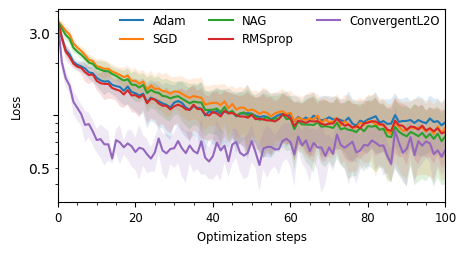

In [ ]:
### Plotting

# import matplotlib.pyplot as plt
# # Avoid type 3 characters (?)
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

test_acc_L2O_all_detached = test_acc_L2O_all.detach().cpu().numpy()
test_acc_Adam_all_detached = test_acc_Adam_all.detach().cpu().numpy()
test_acc_SGD_all_detached = test_acc_SGD_all.detach().cpu().numpy()
test_acc_NAG_all_detached = test_acc_NAG_all.detach().cpu().numpy()
test_acc_RMSprop_all_detached = test_acc_RMSprop_all.detach().cpu().numpy()

print(f'Accuracy of the network on the 10000 test images (L2O) time 20: {100 * test_acc_L2O_all_detached[:,20].mean(axis=0)}% - {100 * test_acc_L2O_all_detached[:,20].std(axis=0)}%\n')
for j in range(trials_Adam):
    print(f'Accuracy of the network on the 10000 test images (Adam {lrs_Adam[j]}  time 20): {100 * test_acc_Adam_all_detached[:, 20, j].mean(axis=0)}% - {100 * test_acc_Adam_all_detached[:, 20, j].std(axis=0)}%\n')
for j in range(trials_SGD):
    print(f'Accuracy of the network on the 10000 test images (SGD {lrs_SGD[j]}  time 20): {100 * test_acc_SGD_all_detached[:, 20, j].mean(axis=0)}% - {100 * test_acc_SGD_all_detached[:, 20, j].std(axis=0)}%\n')
for j in range(trials_NAG):
    print(f'Accuracy of the network on the 10000 test images (NAG {lrs_NAG[j]}  time 20): {100 * test_acc_NAG_all_detached[:, 20, j].mean(axis=0)}% - {100 * test_acc_NAG_all_detached[:, 20, j].std(axis=0)}%\n')
for j in range(trials_RMSprop):
    print(f'Accuracy of the network on the 10000 test images (RMSprop {lrs_RMSprop[j]}  time 20): {100 * test_acc_RMSprop_all_detached[:, 20, j].mean(axis=0)}% - {100 * test_acc_RMSprop_all_detached[:, 20, j].std(axis=0)}%\n')


print(f'Accuracy of the network on the 10000 test images (L2O) time 100: {100 * test_acc_L2O_all_detached[:,T-1].mean(axis=0)}% - {100 * test_acc_L2O_all_detached[:,T-1].std(axis=0)}%\n')
for j in range(trials_Adam):
    print(f'Accuracy of the network on the 10000 test images (Adam {lrs_Adam[j]}) time 100: {100 * test_acc_Adam_all_detached[:, T-1, j].mean(axis=0)}% - {100 * test_acc_Adam_all_detached[:, T-1, j].std(axis=0)}%\n')
for j in range(trials_SGD):
    print(f'Accuracy of the network on the 10000 test images (SGD {lrs_SGD[j]}) time 100: {100 * test_acc_SGD_all_detached[:, T-1, j].mean(axis=0)}% - {100 * test_acc_SGD_all_detached[:, T-1, j].std(axis=0)}%\n')
for j in range(trials_NAG):
    print(f'Accuracy of the network on the 10000 test images (NAG {lrs_NAG[j]}) time 100: {100 * test_acc_NAG_all_detached[:, T-1, j].mean(axis=0)}% - {100 * test_acc_NAG_all_detached[:, T-1, j].std(axis=0)}%\n')
for j in range(trials_RMSprop):
    print(f'Accuracy of the network on the 10000 test images (RMSprop {lrs_RMSprop[j]}) time 100: {100 * test_acc_RMSprop_all_detached[:, T-1, j].mean(axis=0)}% - {100 * test_acc_RMSprop_all_detached[:, T-1, j].std(axis=0)}%\n')

loss_Adam_all_detached = loss_Adam_all.detach().cpu().numpy()
loss_SGD_all_detached = loss_SGD_all.detach().cpu().numpy()
loss_NAG_all_detached = loss_NAG_all.detach().cpu().numpy()
loss_RMSprop_all_detached = loss_RMSprop_all.detach().cpu().numpy()
loss_L2O_all_detached = loss_L2O_all.detach().cpu().numpy()


plt.figure(figsize=(5, 2.5))

for j in range(trials_Adam):
    avg_loss_Adam_all = loss_Adam_all_detached[:, :, j].mean(axis=0)
    std_loss_Adam_all = loss_Adam_all_detached[:, :, j].std(axis=0)
    plt.plot(avg_loss_Adam_all, label=f'Adam')
    plt.fill_between(range(len(avg_loss_Adam_all)), avg_loss_Adam_all - std_loss_Adam_all, avg_loss_Adam_all + std_loss_Adam_all, alpha=0.15)

for j in range(trials_SGD):
    avg_loss_SGD_all = loss_SGD_all_detached[:, :, j].mean(axis=0)
    std_loss_SGD_all = loss_SGD_all_detached[:, :, j].std(axis=0)
    plt.plot(avg_loss_SGD_all, label=f'SGD')
    plt.fill_between(range(len(avg_loss_SGD_all)), avg_loss_SGD_all - std_loss_SGD_all, avg_loss_SGD_all + std_loss_SGD_all, alpha=0.15)

for j in range(trials_NAG):
    avg_loss_NAG_all = loss_NAG_all_detached[:, :, j].mean(axis=0)
    std_loss_NAG_all = loss_NAG_all_detached[:, :, j].std(axis=0)
    plt.plot(avg_loss_NAG_all, label='NAG')
    plt.fill_between(range(len(avg_loss_NAG_all)), avg_loss_NAG_all - std_loss_NAG_all, avg_loss_NAG_all + std_loss_NAG_all, alpha=0.15)

for j in range(trials_RMSprop):
    avg_loss_RMSprop_all = loss_RMSprop_all_detached[:, :, j].mean(axis=0)
    std_loss_RMSprop_all = loss_RMSprop_all_detached[:, :, j].std(axis=0)
    plt.plot(avg_loss_RMSprop_all, label='RMSprop')
    plt.fill_between(range(len(avg_loss_RMSprop_all)), avg_loss_RMSprop_all - std_loss_RMSprop_all, avg_loss_RMSprop_all + std_loss_RMSprop_all, alpha=0.15)

avg_loss_L2O_all = loss_L2O_all_detached.mean(axis=0)
std_loss_L2O_all = loss_L2O_all_detached.std(axis=0)
plt.plot(avg_loss_L2O_all, label='ConvergentL2O')
plt.fill_between(range(len(avg_loss_L2O_all)), avg_loss_L2O_all - std_loss_L2O_all, avg_loss_L2O_all + std_loss_L2O_all, alpha=0.15)




from matplotlib.ticker import LogFormatter, FuncFormatter


plt.xlim(0, T-1)
plt.xticks(np.arange(0, T, step=20), fontsize='small')

plt.yscale('log')
plt.minorticks_on()  # Ensure minor ticks are on

# Custom formatter to show labels only for 10^0 and 10^1 in mathematical notation
def custom_formatter(val, pos):
    if val >= 3 and val <= 3.9:  # 10^0
        return f'{val}'
    elif  val <0.6 and val>0.4:  # 10^1
        return f'{val}'
    else:
        return ''  # No label for minor ticks and other values

plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.gca().yaxis.set_minor_formatter(FuncFormatter(custom_formatter))

#plt.gca().set_position([0, 0, 0.8, 0.7])


plt.xlabel('Optimization steps', fontsize='small')
plt.ylabel('Loss', fontsize='small')
plt.legend(loc='upper center', bbox_to_anchor=(0.573, 1.03), ncol=3, frameon=False, fontsize = 'small')

file_plot_path = '/content/drive/MyDrive/Colab Notebooks/Plots/FINAL_080324/FINAL_relu_normal.pdf'
plt.savefig(file_plot_path, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()




In [ ]:
print(loss_SGD_all_detached[0, :, 0])

[2.326015  2.328853  2.3064568 2.2713168 2.27628   2.233562  2.2344394
 2.214978  2.1611507 2.1459005 2.0892458 2.096123  2.0604076 2.07328
 2.0342827 1.9832703 1.9773036 1.9787362 1.9692516 1.9225192 1.8947239
 1.89359   1.8825412 1.8726864 1.8436646 1.855203  1.8649135 1.8603466
 1.8033187 1.8144404 1.8256775 1.8060688 1.7651975 1.7833117 1.77345
 1.8057715 1.7828788 1.7610755 1.7598319 1.7531472 1.7643754 1.765411
 1.7625465 1.7367872 1.7534776 1.7542297 1.7178296 1.7934636 1.7153478
 1.7347759 1.7606564 1.7412366 1.7183836 1.7328389 1.7439556 1.7508886
 1.7039284 1.7322198 1.7507569 1.7227871 1.7146035 1.72964   1.7255702
 1.7559295 1.6893473 1.7045848 1.702971  1.7131442 1.7495648 1.707404
 1.7309506 1.707825  1.7137698 1.7132633 1.7326297 1.751378  1.7006682
 1.6823753 1.7330171 1.6620351 1.6921738 1.7056949 1.695745  1.6972985
 1.6674727 1.6520939 1.6821259 1.7591168 1.7152886 1.6735585 1.6786195
 1.7204    1.688751  1.6955583 1.6634343 1.6703357 1.6692197 1.6874987
 1.6828302 1

In [ ]:
### Panic cell

# for t in range(10):

#         try:
#             images, labels = next(trainloader_iter)
#         except StopIteration:
#             trainloader_iter = iter(trainloader)
#             images, labels = next(trainloader_iter)

#         images = images.to(device)
#         labels = labels.to(device)
#         inputs = images.view(images.shape[0], -1)

#         logits_tanh = forward_propagation(inputs, weights, bias, 'tanh')
#         logits_sigmoid = forward_propagation(inputs, weights, bias, 'sigmoid')
#         logits_relu = forward_propagation(inputs, weights, bias, 'relu')
#         loss_tanh = criterion(logits_tanh, labels)
#         loss_sigmoid = criterion(logits_sigmoid, labels)
#         loss_relu = criterion(logits_relu, labels)

#         print(f'loss tanh: {loss_tanh}, loss sigmoid: {loss_sigmoid}, loss relu: {loss_relu}\n')



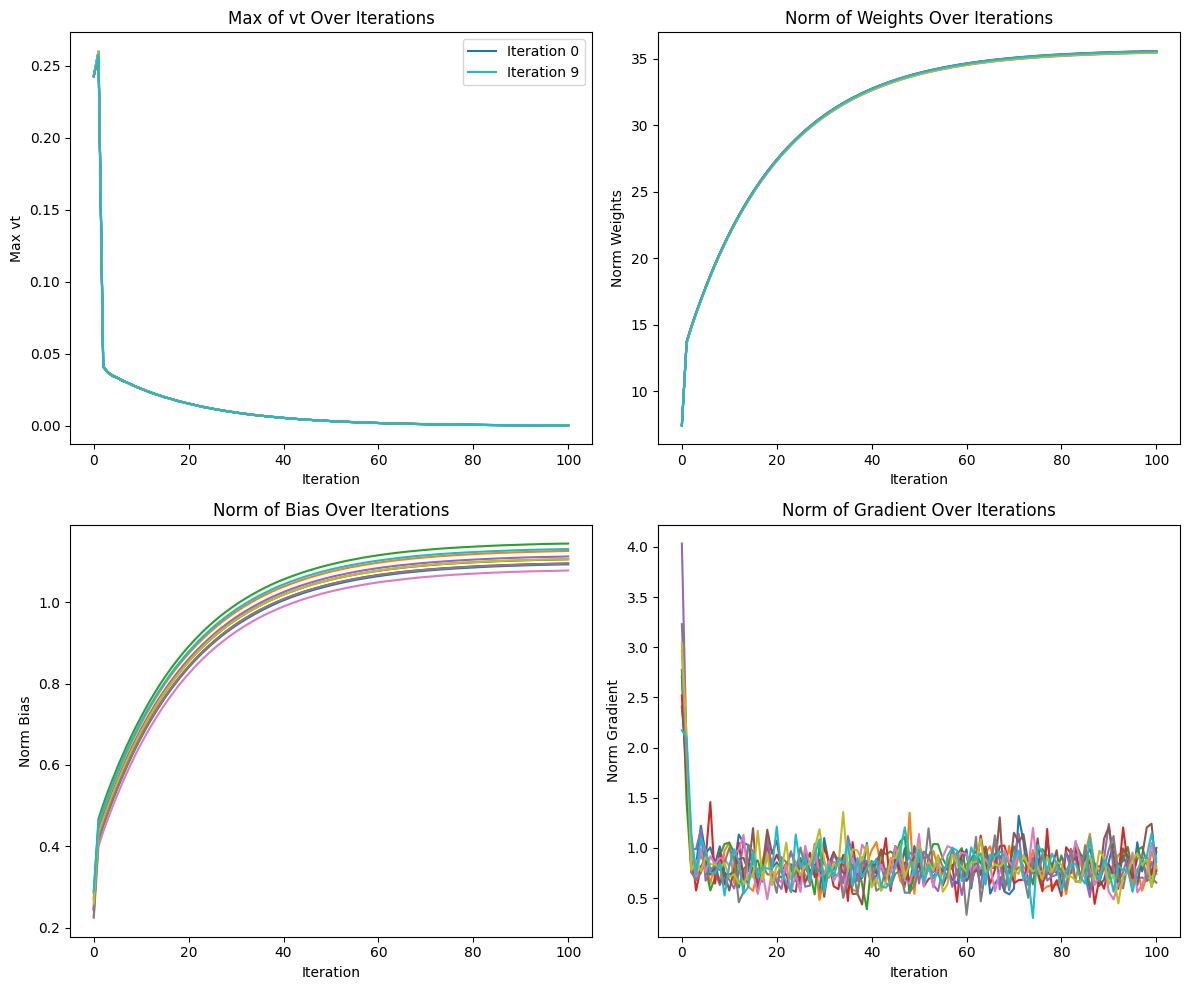

In [ ]:
norm_vt_all_detached =norm_vt_all.detach().cpu().numpy()
norm_weightst_all_detached =norm_weightst_all.detach().cpu().numpy()
norm_biast_all_detached =norm_biast_all.detach().cpu().numpy()
norm_gradt_all_detached =norm_gradt_all.detach().cpu().numpy()


# avg_norm_vt_all = norm_vt_all_detached.mean(axis=0)
# std_norm_vt_all = norm_vt_all_detached.std(axis=0)
# avg_norm_weightst_all = norm_weightst_all_detached.mean(axis=0)
# std_norm_weightst_all = norm_weightst_all_detached.std(axis=0)
# avg_norm_biast_all = norm_biast_all_detached.mean(axis=0)
# std_norm_biast_all = norm_biast_all_detached.std(axis=0)
# avg_norm_gradt_all = norm_gradt_all_detached.mean(axis=0)
# std_norm_gradt_all = norm_gradt_all_detached.std(axis=0)

# Creating a figure for subplots
plt.figure(figsize=(12, 10))

# Subplot for norm_vt_all
plt.subplot(2, 2, 1) # This means 2 rows, 2 columns, position 1
for j in range(iterations):
    plt.plot(norm_vt_all_detached[j, :], label=f'Iteration {j}' if j in [0, iterations-1] else "")
plt.title('Max of vt Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Max vt')

# Subplot for norm_weightst_all
plt.subplot(2, 2, 2) # This means 2 rows, 2 columns, position 2
for j in range(iterations):
    plt.plot(norm_weightst_all_detached[j, :], label=f'Iteration {j}' if j in [0, iterations-1] else "")
plt.title('Norm of Weights Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Norm Weights')

# Subplot for norm_biast_all
plt.subplot(2, 2, 3) # This means 2 rows, 2 columns, position 3
for j in range(iterations):
    plt.plot(norm_biast_all_detached[j, :], label=f'Iteration {j}' if j in [0, iterations-1] else "")
plt.title('Norm of Bias Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Norm Bias')

# Subplot for norm_gradt_all
plt.subplot(2, 2, 4) # This means 2 rows, 2 columns, position 4
for j in range(iterations):
    plt.plot(norm_gradt_all_detached[j, :], label=f'Iteration {j}' if j in [0, iterations-1] else "")
plt.title('Norm of Gradient Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Norm Gradient')

# Adding a legend to the first subplot for clarity, adjust as needed
plt.subplot(2, 2, 1)
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()





